In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from functions import *

random.seed(26)
np.random.seed(26)

In [2]:
ds = pd.read_csv("poly_regression_large.csv")
# Inspect the data
print(f"Shape of the data: {ds.shape}")
# Convert data into a matrix
data = np.array(ds)

# Extract the test part
X = data[:, 1]
Y = data[:, 2]
_, (X_test, Y_test) = split_data(X, Y, per_train=0.8)

train_csv = pd.read_csv("poly_regression_small.csv")
train = np.array(train_csv)
X_train, Y_train = train[:, 1], train[:, 2]
print(f"Shape of the training data: {X_train.shape}")

Shape of the data: (1000, 3)
Train test split = 800, 200
Shape of the training data: (50,)


In [3]:
titles_MLE = ["$\\theta_{MLE}$ using GD", "$\\theta_{MLE}$ using SGD", "$\\theta_{MLE}$ using Normal Equation"]
titles_MAP = ["$\\theta_{MAP}$ using GD", "$\\theta_{MAP}$ using SGD", "$\\theta_{MAP}$ using Normal Equation"]
train_data = (X_train, Y_train)
kk = list(range(2,12)) # polynomial degrees


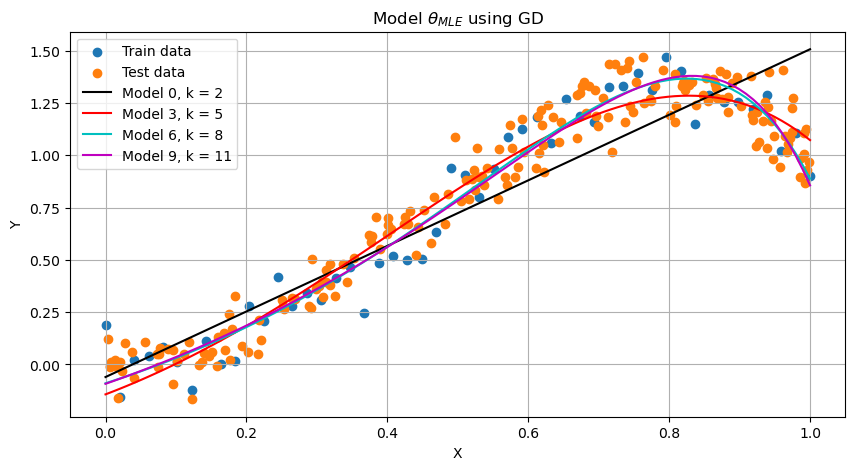

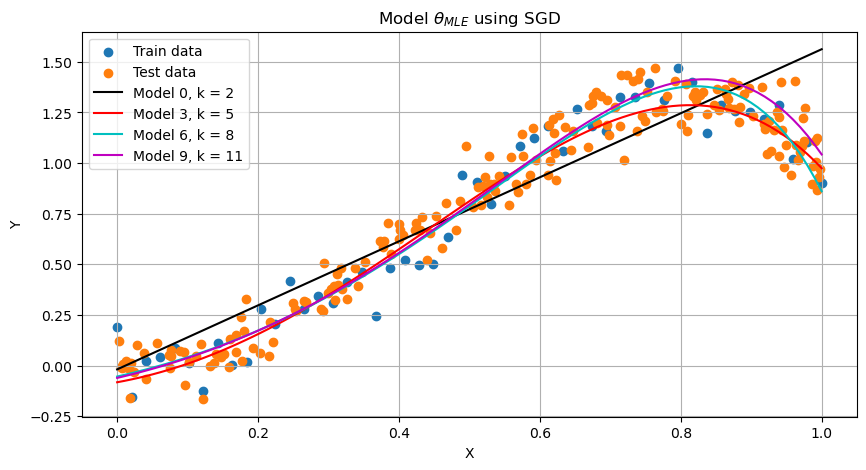

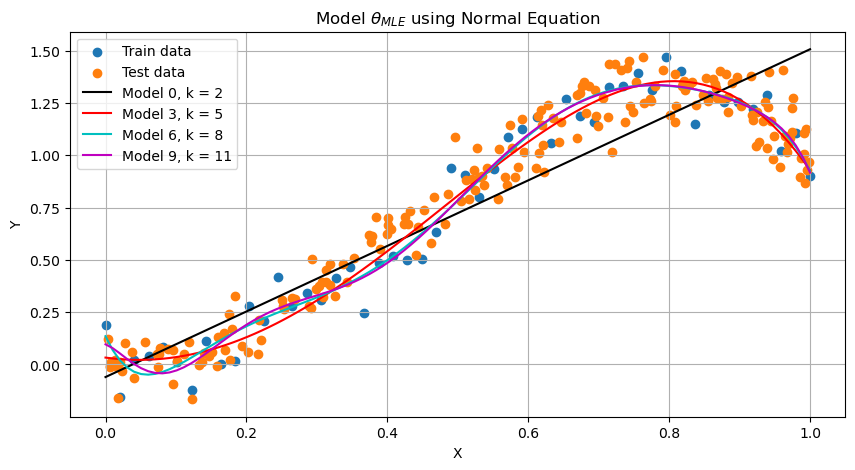

In [4]:
# data needed for GD
epoch_or_iter = 500
# MLE GD
thetas_history_GD_MLE, converging_kk_history_GD_MLE = compute_weights(
    'GD', 'MLE', kk, train_data, loss=loss_MLE
    , grad_loss=grad_loss_MLE, kmax=epoch_or_iter)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, thetas_history_GD_MLE, 
    title=titles_MLE[0])

# data needed for SGD
batch_size = 5
alpha = 0.1
# MLE SGD
thetas_history_SGD_MLE, converging_kk_history_SGD_MLE = compute_weights(
     'SGD', 'MLE', kk ,train_data,loss=loss_MLE, 
     grad_loss=grad_loss_MLE,batch_size = batch_size, 
     n_epochs=epoch_or_iter, alpha = 0.1)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, thetas_history_SGD_MLE,
    title=titles_MLE[1])

# data needed for Normal
# MLE Normal
thetas_history_norm_MLE, converging_kk_history = compute_weights(
    'Normal', 'MLE', kk ,train_data)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, thetas_history_norm_MLE
    ,title=titles_MLE[2])

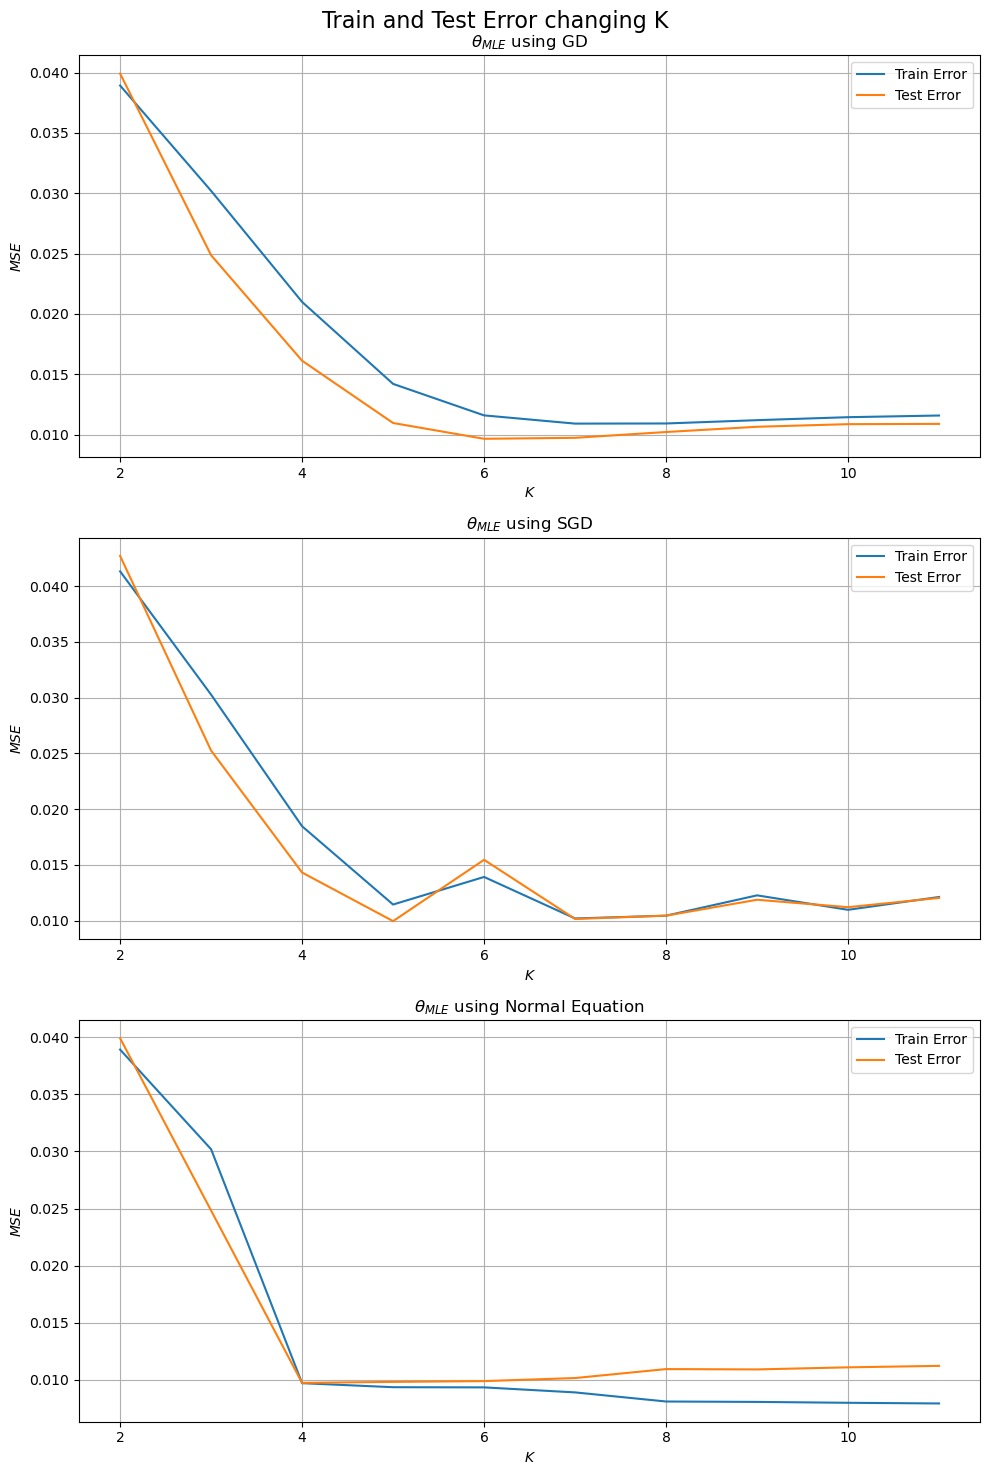

In [5]:
#plot the train and test error respect to k
theta_histories = [thetas_history_GD_MLE, thetas_history_SGD_MLE, thetas_history_norm_MLE]
plot_train_test_error_respect_to_k(X_train, Y_train, X_test, Y_test, theta_histories, titles=titles_MLE)

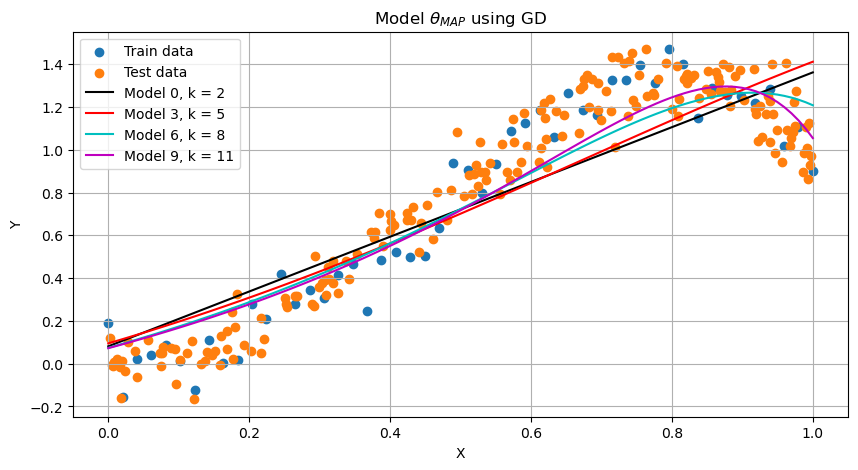

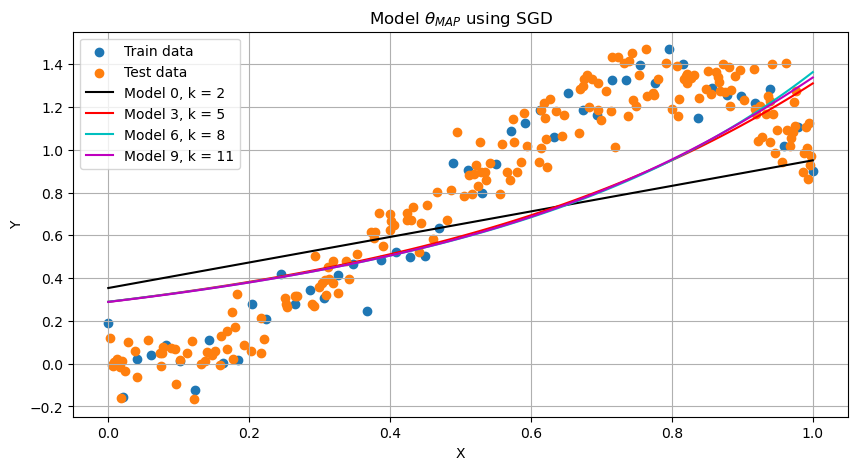

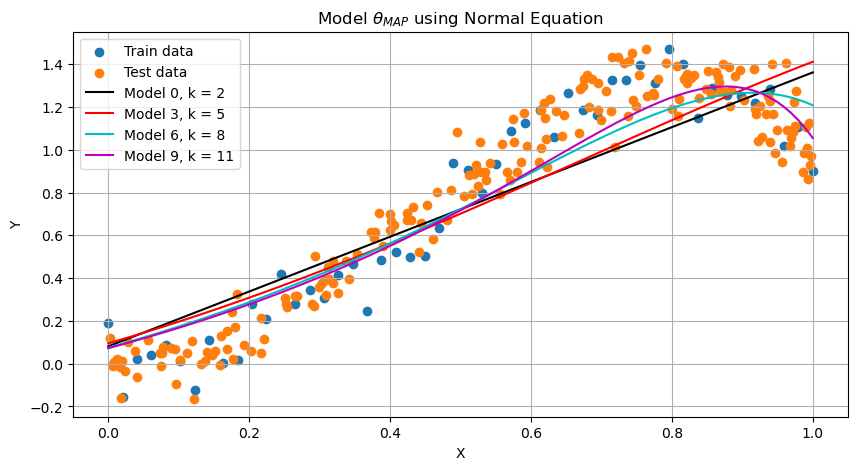

In [6]:
# universal data needed for MAP
lam = 1

# data needed for GD
epoch_or_iter = 500
# MAP GD
thetas_history_GD_MAP, converging_kk_history_GD_MAP = compute_weights(
    'GD', 'MAP', kk, train_data, lam = lam, loss=loss_MAP
    , grad_loss=grad_loss_MAP, kmax=epoch_or_iter)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, thetas_history_GD_MAP, 
    title=titles_MAP[0])
    

# data needed for SGD
batch_size = 5
alpha = 0.001
# MAP SGD
thetas_history_SGD_MAP, converging_kk_history_SGD_MAP = compute_weights(
     'SGD', 'MAP', kk ,train_data, lam = lam,loss=loss_MAP, 
     grad_loss=grad_loss_MAP,batch_size = batch_size, 
     n_epochs=epoch_or_iter, alpha = alpha)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, thetas_history_SGD_MAP,
    title=titles_MAP[1])

# data needed for Normal
# MAP Normal
thetas_history_norm_MAP, converging_kk_history = compute_weights(
    'Normal', 'MAP', kk ,train_data, lam= lam)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, thetas_history_norm_MAP
    ,title=titles_MAP[2])

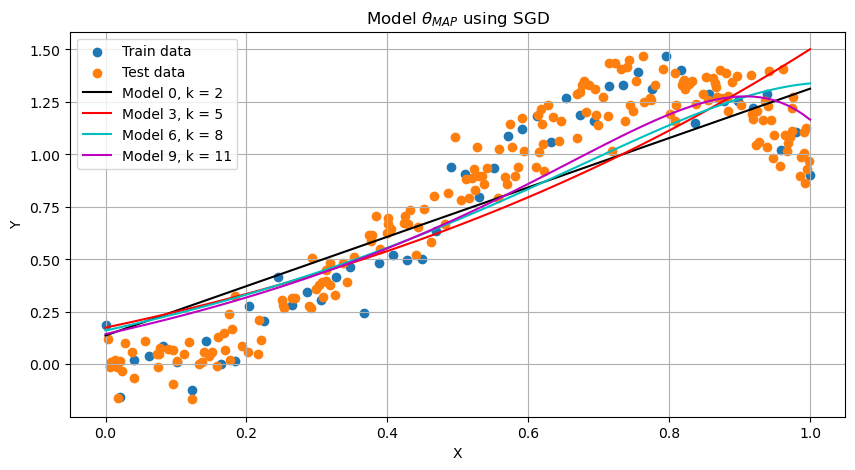

In [7]:
alpha = 0.001
# MAP SGD
thetas_history_SGD_MAP, converging_kk_history_SGD_MAP = compute_weights(
     'SGD', 'MAP', kk ,train_data, lam = lam,loss=loss_MAP, 
     grad_loss=grad_loss_MAP,batch_size = 50, 
     n_epochs=epoch_or_iter, alpha = alpha)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, thetas_history_SGD_MAP,
    title=titles_MAP[1])

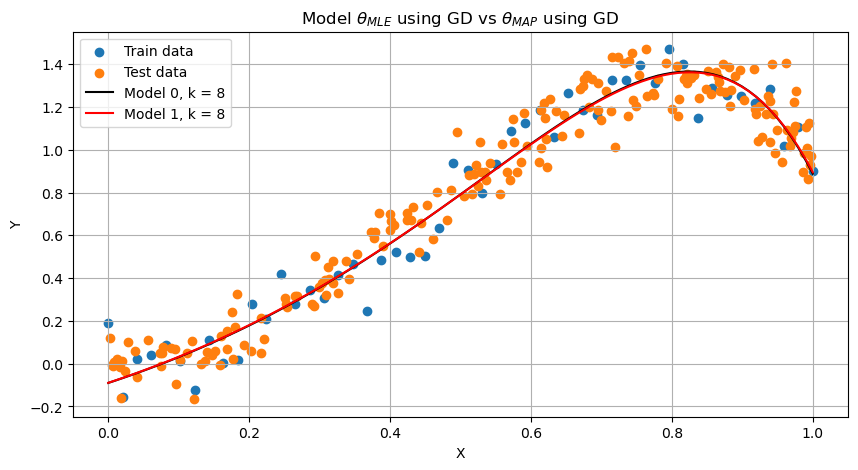

Mean Squared Error of the Test for MLE:  0.0102
Mean Squared Error of the Test for MAP:  0.0102
Mean Squared Error of the Train for MLE:  0.0109
Mean Squared Error of the Train for MAP:  0.011


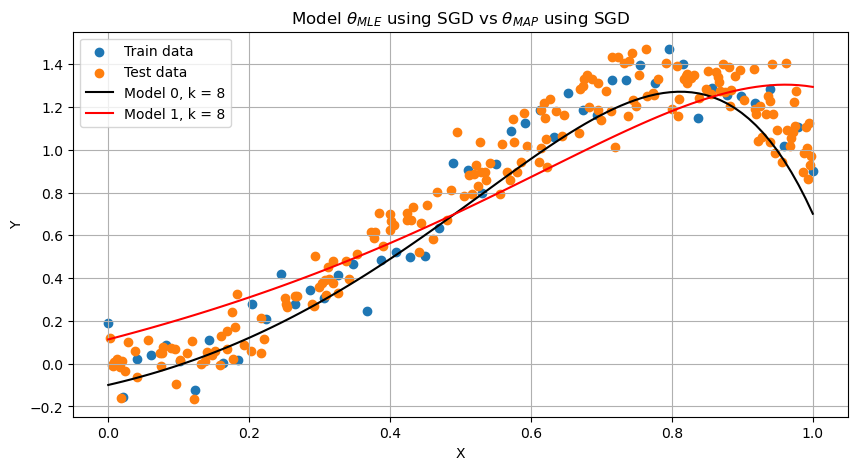

Mean Squared Error of the Test for MLE:  0.0203
Mean Squared Error of the Test for MAP:  0.0328
Mean Squared Error of the Train for MLE:  0.0174
Mean Squared Error of the Train for MAP:  0.0355


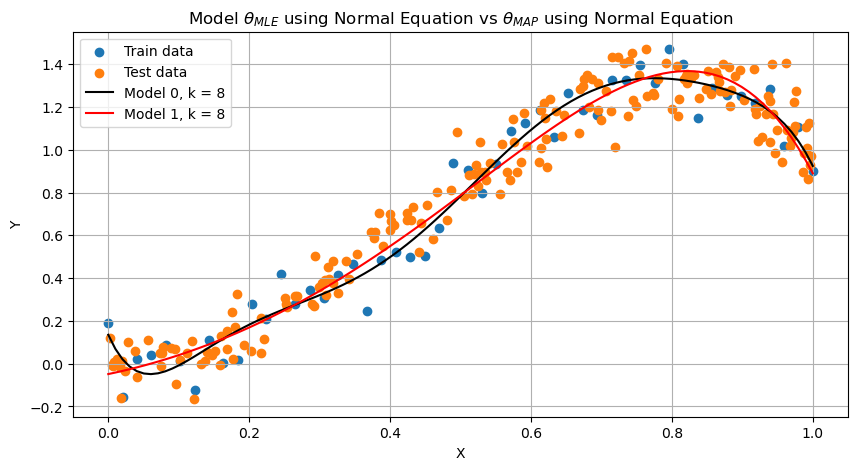

Mean Squared Error of the Test for MLE:  0.0109
Mean Squared Error of the Test for MAP:  0.0101
Mean Squared Error of the Train for MLE:  0.0081
Mean Squared Error of the Train for MAP:  0.0102


In [8]:
# universal data needed for MAP
lam = 0.01
kk = 8

# data needed for GD
epoch_or_iter = 500
# MAP GD
thetas_history_GD_MAP, converging_kk_history_GD_MAP = compute_weights(
    'GD', 'MAP', kk, train_data, lam = lam, loss=loss_MAP
    , grad_loss=grad_loss_MAP, kmax=epoch_or_iter)
# MLE GD
thetas_history_GD_MLE, converging_kk_history_GD_MLE = compute_weights(
    'GD', 'MLE', kk, train_data, loss=loss_MLE
    , grad_loss=grad_loss_MLE, kmax=epoch_or_iter)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, [thetas_history_GD_MLE[-1], thetas_history_GD_MAP[-1]], 
    title=(titles_MLE[0]+" vs "+titles_MAP[0]), VS = True)
print("Mean Squared Error of the Test for MLE: ", round(mse_error(X_test, Y_test, thetas_history_GD_MLE[-1]),4))
print("Mean Squared Error of the Test for MAP: ", round(mse_error(X_test, Y_test, thetas_history_GD_MAP[-1]),4))
print("Mean Squared Error of the Train for MLE: ", round(mse_error(X_train, Y_train, thetas_history_GD_MLE[-1]),4))
print("Mean Squared Error of the Train for MAP: ", round(mse_error(X_train, Y_train, thetas_history_GD_MAP[-1]),4))

#-----------------------------------------------------------------------------------------------------------
# data needed for SGD
batch_size = 50
alpha = 0.001
# MLE SGD
thetas_history_SGD_MLE, converging_kk_history_SGD_MLE = compute_weights(
     'SGD', 'MLE', kk ,train_data,loss=loss_MLE, 
     grad_loss=grad_loss_MLE,batch_size = 5, 
     n_epochs=epoch_or_iter, alpha = 0.1)
# MAP SGD
thetas_history_SGD_MAP, converging_kk_history_SGD_MAP = compute_weights(
     'SGD', 'MAP', kk ,train_data, lam = lam,loss=loss_MAP, 
     grad_loss=grad_loss_MAP,batch_size = batch_size, 
     n_epochs=epoch_or_iter, alpha = alpha)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, [thetas_history_SGD_MLE[-1], thetas_history_SGD_MAP[-1]],
    title=(titles_MLE[1]+" vs "+titles_MAP[1]), VS = True)
print("Mean Squared Error of the Test for MLE: ", round(mse_error(X_test, Y_test, thetas_history_SGD_MLE[-1]),4))
print("Mean Squared Error of the Test for MAP: ", round(mse_error(X_test, Y_test, thetas_history_SGD_MAP[-1]),4))
print("Mean Squared Error of the Train for MLE: ", round(mse_error(X_train, Y_train, thetas_history_SGD_MLE[-1]),4))
print("Mean Squared Error of the Train for MAP: ", round(mse_error(X_train, Y_train, thetas_history_SGD_MAP[-1]),4))

#-----------------------------------------------------------------------------------------------------------
# data needed for Normal
# MLE Normal
thetas_history_norm_MLE, converging_kk_history = compute_weights(
    'Normal', 'MLE', kk ,train_data)
# MAP Normal
thetas_history_norm_MAP, converging_kk_history = compute_weights(
    'Normal', 'MAP', kk ,train_data, lam= lam)
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, [thetas_history_norm_MLE[-1],thetas_history_norm_MAP[-1]]
    ,title=(titles_MLE[2]+" vs "+titles_MAP[2]), VS = True)

print("Mean Squared Error of the Test for MLE: ", round(mse_error(X_test, Y_test, thetas_history_norm_MLE[-1]),4))
print("Mean Squared Error of the Test for MAP: ", round(mse_error(X_test, Y_test, thetas_history_norm_MAP[-1]),4))
print("Mean Squared Error of the Train for MLE: ", round(mse_error(X_train, Y_train, thetas_history_norm_MLE[-1]),4))
print("Mean Squared Error of the Train for MAP: ", round(mse_error(X_train, Y_train, thetas_history_norm_MAP[-1]),4))


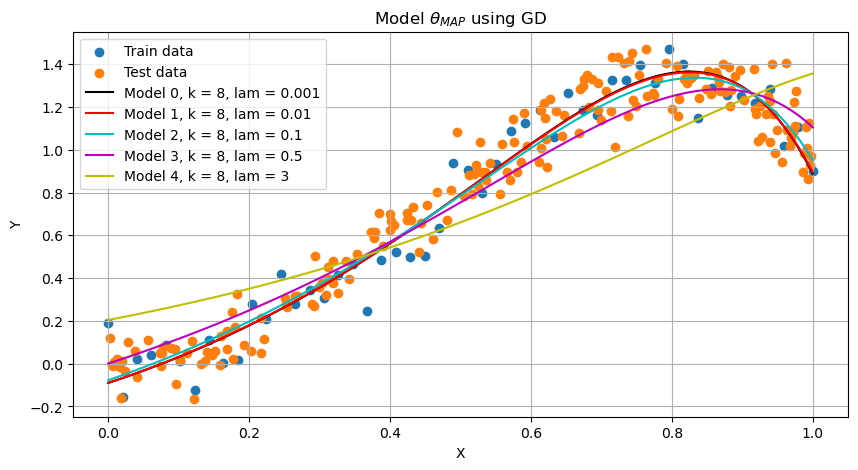

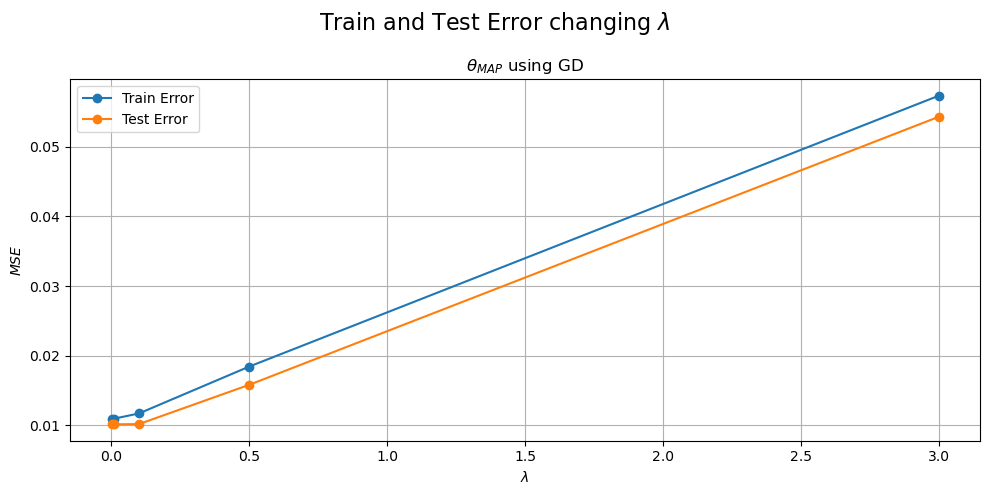

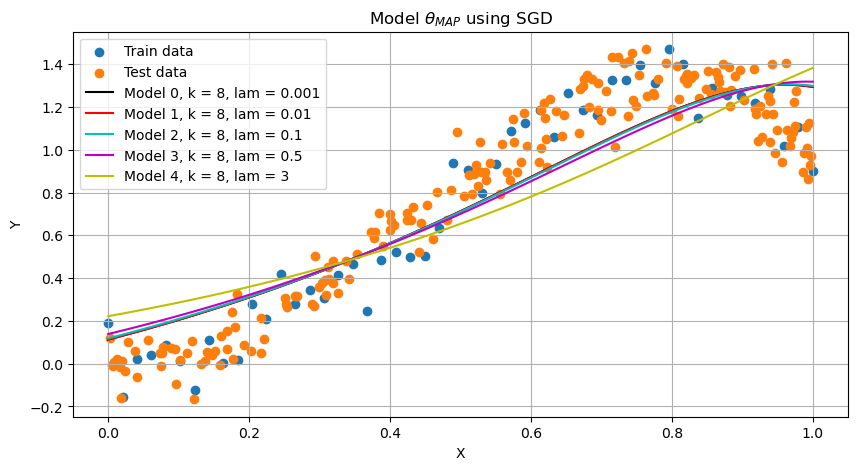

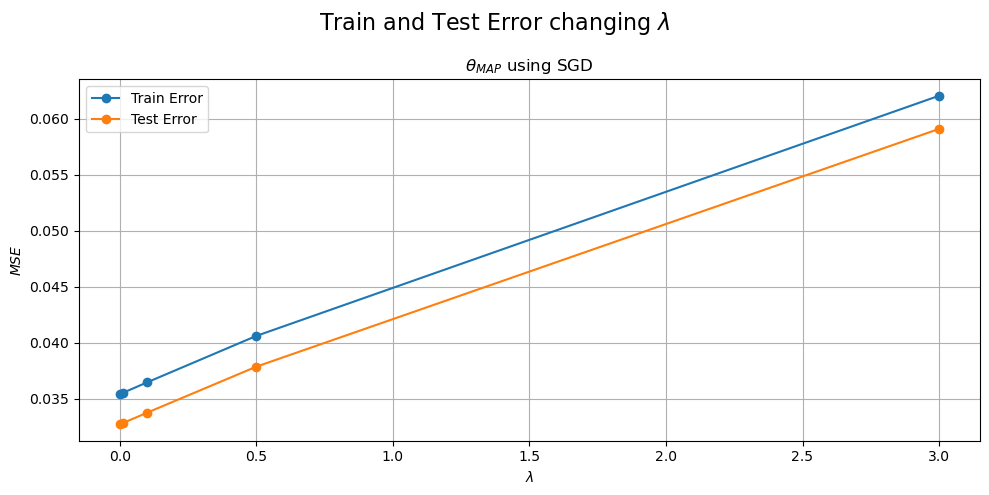

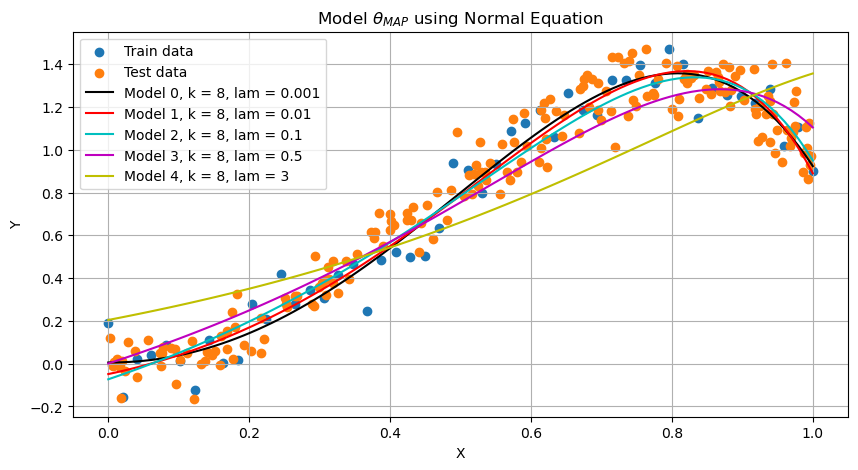

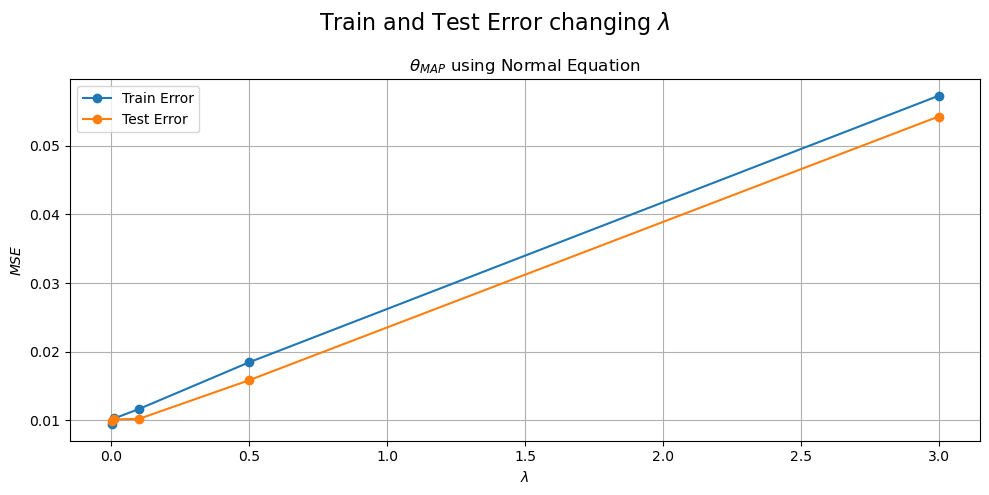

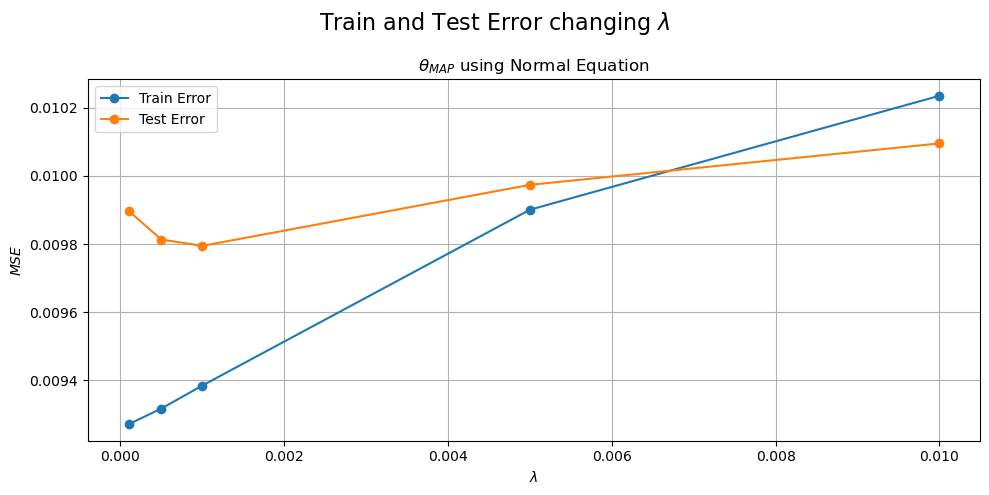

In [9]:
# universal data needed for MAP
lamds = [0.001 ,0.01,0.1,0.5,3]
kk = 8

theta_histories_lambda = []
for lam in lamds:
    # data needed for GD
    epoch_or_iter = 500
    # MAP GD
    thetas_history_GD_MAP, converging_kk_history_GD_MAP = compute_weights(
        'GD', 'MAP', kk, train_data, lam = lam, loss=loss_MAP
        , grad_loss=grad_loss_MAP, kmax=epoch_or_iter)
    theta_histories_lambda.append(thetas_history_GD_MAP[-1])
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, theta_histories_lambda, 
    title=titles_MAP[0], VS = True, lamds = lamds)

plot_train_test_error_respect_to_lambda(X_train, Y_train, X_test, 
    Y_test, theta_histories_lambda, lamds, titles_MAP[0])

theta_histories_lambda = []
for lam in lamds:
    # data needed for SGD
    batch_size = 50
    alpha = 0.001
    # MAP SGD
    thetas_history_SGD_MAP, converging_kk_history_SGD_MAP = compute_weights(
        'SGD', 'MAP', kk ,train_data, lam = lam,loss=loss_MAP, 
        grad_loss=grad_loss_MAP,batch_size = batch_size, 
        n_epochs=epoch_or_iter, alpha = alpha)
    theta_histories_lambda.append(thetas_history_SGD_MAP[-1])
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, theta_histories_lambda,
    title=titles_MAP[1], VS = True, lamds = lamds)
plot_train_test_error_respect_to_lambda(X_train, Y_train, X_test, 
    Y_test, theta_histories_lambda, lamds, titles_MAP[1])

theta_histories_lambda = []
for lam in lamds:
    # data needed for Normal
    # MAP Normal
    thetas_history_norm_MAP, converging_kk_history = compute_weights(
        'Normal', 'MAP', kk ,train_data, lam= lam)
    theta_histories_lambda.append(thetas_history_norm_MAP[-1])
# plot
plot_poly_regression(
    X_train, Y_train, X_test, Y_test, theta_histories_lambda
    ,title=titles_MAP[2], VS = True, lamds = lamds)
plot_train_test_error_respect_to_lambda(X_train, Y_train, X_test, 
    Y_test, theta_histories_lambda, lamds, titles_MAP[2])


theta_histories_lambda = []
lamds = [0.0001, 0.0005,0.001, 0.005, 0.01]
for lam in lamds:
    # data needed for Normal
    # MAP Normal
    thetas_history_norm_MAP, converging_kk_history = compute_weights(
        'Normal', 'MAP', kk ,train_data, lam= lam)
    theta_histories_lambda.append(thetas_history_norm_MAP[-1])

plot_train_test_error_respect_to_lambda(X_train, Y_train, X_test, 
    Y_test, theta_histories_lambda, lamds, titles_MAP[2])